# Logistic fits to stimulus-based condition

This script is used for model comparison for the stimulus-based logistic fits to the psychometric function in section:
"Rule- and stimulus-based biases had different effects on choices and RTs"

Produces Figure 3.

In [1]:
imatlab_export_fig('print-svg')
set(groot,'defaultfigurecolor',[1 1 1]);
set(groot,'DefaultAxesFontName','Arial')

addpath('../logistic')

DATA_DIR = './data';

%pretene main effects/interactions
fitspt1(1).fitmat = 'fits_lapse_pretoneOnly_full6_07-Mar-2021.mat';
fitspt1(1).model_id = 1;
fitspt1(1).mname = 'full';
fitspt1(1).lastparam = 15;
fitspt1(1).ptlens = 6;
fitspt1(1).dmatfunc = @make_pretone_dmat;
fitspt1(2).fitmat = 'fits_lapse_pretoneOnly_noint6_07-Mar-2021.mat';
fitspt1(2).model_id = 2;
fitspt1(2).mname = 'no interaction';
fitspt1(2).lastparam = 9;
fitspt1(2).ptlens = 6;
fitspt1(2).dmatfunc = @make_pretone_noint_dmat;
fitspt1(3).fitmat = 'fits_lapse_pretoneOnly_full0_07-Mar-2021.mat';
fitspt1(3).model_id = 3;
fitspt1(3).mname = 'base';
fitspt1(3).lastparam = 3;
fitspt1(3).ptlens = 0;
fitspt1(3).dmatfunc = @make_pretone_dmat;

data = read_data_csv(...
    fullfile(DATA_DIR,'/priorOnly_pretoneOnly_pretone_pL_pretone_pH_pretone5_05-Feb-2021.csv'));    

## PretoneOnly condition

### Modeling individual pretone effects 

To get a sense for the effect of individual pretones on the final choice, I ran a series of logistic regression models with predictors that mirror those of the DDM models. Namely, regressions were of the form

$$logit(\pi) = \beta_0 + \beta_{SNR}SNR + \sum_{i=1}^{pt_{max}}\beta_{pt_i}pt_i + \sum_{i=1}^{pt_{max}}\beta_{pt_i:|SNR|}pt_i|SNR|,$$

where $\pi$ is the probability of responding that the tone was high, $SNR$ is the signed signal-to-noise ratio of the test tone (positive = high tones, negative = low tones), $|SNR|$ is the unsigned signal-to-noise ratio of the test tone (both $SNR$ and $|SNR|$ were was z-scored to improve the stability of the fits), $pt_i$ is pretone at position $i$, where $pt_1$ is last pretone presented (the pretone immediately prior to the test tone) and $pt_{max}$ is the first pretone (the pretone furthest in time from the test tone). The SNR-dependent adaptation effect was modeled as the interaction $pt_i:|SNR|$. Pretones were coded $[0.5,-0.5]$ s.t. $\beta_{pt_i}$ is the log-odds ratio $tone_{high}:tone_{low}$ at an SNR of 0. 

In [2]:
%extract pt data and conditions
datapt = data(strcmp(data.optionName,'pretoneOnly') & ~isnan(data.choice01),:);

%set up variables (since this happens multiple places should maybe eventually be a function...)
datapt.zSNR = zscore(datapt.SNR);
datapt.nozaSNR = abs(datapt.SNR);
datapt.aSNR = zscore(datapt.nozaSNR);
datapt.pretones = cellfun(@(x) fliplr(replace(x,{'X','H','L'},{'','1','0'})), ...
    datapt.pretoneSeq,'UniformOutput',false);
%convert to numeric and recode as 0.5/-0.5
datapt.pretones = cellfun(@(x) (arrayfun(@str2double,x)-0.5),...
    datapt.pretones,'UniformOutput',false);

SNRs = unique(datapt.SNR);
ptlens = unique(datapt.pretoneLength);
ptsubj = unique(datapt.subject);

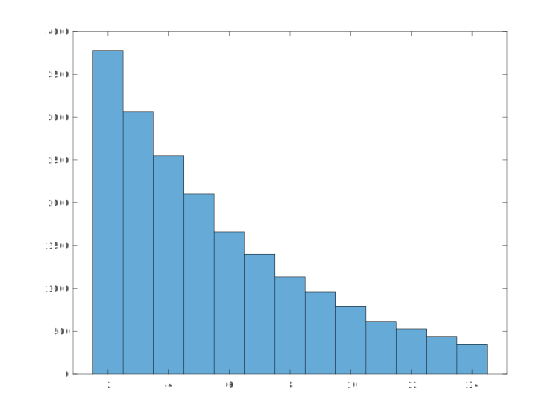

In [3]:
% first we need to establish which pretone lengths are reasonable to fit given data limits

%first overall distribution
figure();histogram(datapt.pretoneLength(~isnan(datapt.choice01)))

%now get counts
snr_len_count = table();
for s=1:length(ptsubj)
    for n=1:length(SNRs)
        this_subj = ptsubj(s);
        this_snr =SNRs(n);
        this_lens = datapt.pretoneLength(strcmp(datapt.subject,this_subj) & datapt.SNR==this_snr);
        this_counts = accumarray(this_lens,1,[14 1],[],0);
        this_counts = this_counts(2:end); %chop off count for 1 as doesn't exist in data
        this_snr_len_count = table(repmat(this_subj,13,1),repmat(this_snr,13,1),[2:14]',...
            this_counts,'VariableNames',{'subject','SNR','pretoneLength','count'});
        snr_len_count = [snr_len_count;this_snr_len_count];
    end
    clear this_subj this_snr this_lens this_counts this_snr_len_count
end

assert(height(snr_len_count)==length(SNRs)*length(ptlens)*length(ptsubj))

%now summarise
pt_SNR_len_ave = summary_stats(snr_len_count,'count',{'pretoneLength'});
pt_SNR_len_min = varfun(@min,snr_len_count,'InputVariables','count',...
    'GroupingVariables',{'pretoneLength'});
pt_SNR_len_max = varfun(@max,snr_len_count,'InputVariables','count',...
    'GroupingVariables',{'pretoneLength'});   


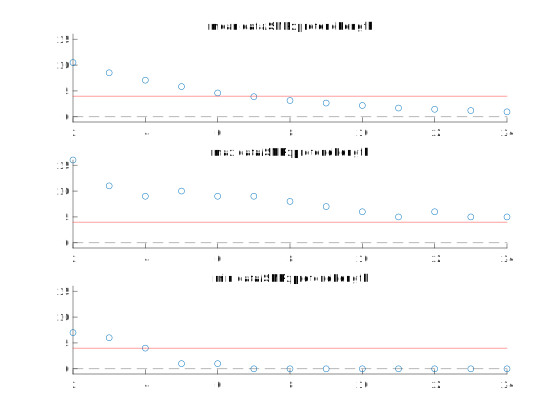

In [4]:
%now plot
figure();
subplot(3,1,1);
scatter(pt_SNR_len_ave.pretoneLength,pt_SNR_len_ave.mean_count)
title('mean data/SNRxpretoneLength')
ylim([-1 16])
yline(0,'--');
yline(4,'-r');
subplot(3,1,2);
scatter(pt_SNR_len_max.pretoneLength,pt_SNR_len_max.max_count)
title('max data/SNRxpretoneLength')
ylim([-1 16])
yline(0,'--');
yline(4,'-r');
subplot(3,1,3);
scatter(pt_SNR_len_min.pretoneLength,pt_SNR_len_min.min_count)
title('min data/SNRxpretoneLength')
ylim([-1 16])
yline(0,'--');
yline(4,'-r');

#### plot full model

In [25]:
%plot full model

F=load(fullfile(DATA_DIR,fitspt1(1).fitmat));
fits_lapse = F.fits_lapse; 
clear F;
   
%fit_pred = table();
dmat_func = @(x) make_pretone_dmat(x,6);
datapt.choice_pred = nan(height(datapt),1);
for s=1:length(ptsubj)
    this_data = datapt(strcmp(datapt.subject,ptsubj(s)),:);
    this_fit = fits_lapse{strcmp(fits_lapse.subject,ptsubj(s)),1:15};
    datapt.choice_pred(strcmp(datapt.subject,ptsubj(s))) = ...
        logist_pred(this_data,this_fit,dmat_func);
    clear this_data this_fit
end

datapt_ave_subj = summary_stats(datapt,{'choice01','choice_pred'},...
    {'subject','ptC','zSNR'});

datapt_ave_all = summary_stats(datapt_ave_subj,{'mean_choice01','mean_choice_pred'},...
    {'ptC','zSNR'});

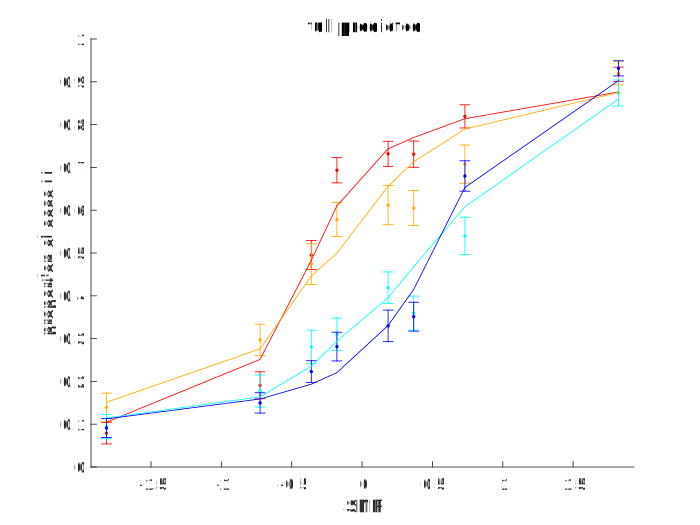

In [26]:
jet11 = mat2cell(jet(11),ones(1,11));
jet4 = jet11([2,5,9,11]);
jet4r = flipud(jet4);

figure();hold on;
h_pt_psychod = psycho_plot(datapt_ave_all,'ptC','.',...
    'mean_mean_choice01','sem_mean_choice01',0,'zSNR');
[h_pt_psychod.Color] = jet4r{:}; 
h_pt_psychop = psycho_plot(datapt_ave_all,'ptC','-',...
    'mean_mean_choice_pred',[],0,'zSNR');
[h_pt_psychop.Color] = jet4r{:}; 
    
xlabel('SNR')
ylabel('proportion choose H')
title('full predicted')

In [23]:
%no adapt
F=load(fullfile(DATA_DIR,fitspt1(2).fitmat));
fits_lapse = F.fits_lapse; 
clear F;
   
%fit_pred = table();
dmat_func = @(x) make_pretone_noint_dmat(x,6);
datapt.choice_pred = nan(height(datapt),1);
for s=1:length(ptsubj)
    this_data = datapt(strcmp(datapt.subject,ptsubj(s)),:);
    this_fit = fits_lapse{strcmp(fits_lapse.subject,ptsubj(s)),1:9};
    datapt.choice_pred(strcmp(datapt.subject,ptsubj(s))) = ...
        logist_pred(this_data,this_fit,dmat_func);
    clear this_data this_fit
end

datapt_ave_subj = summary_stats(datapt,{'choice01','choice_pred'},...
    {'subject','ptC','zSNR'});

datapt_ave_all = summary_stats(datapt_ave_subj,{'mean_choice01','mean_choice_pred'},...
    {'ptC','zSNR'});

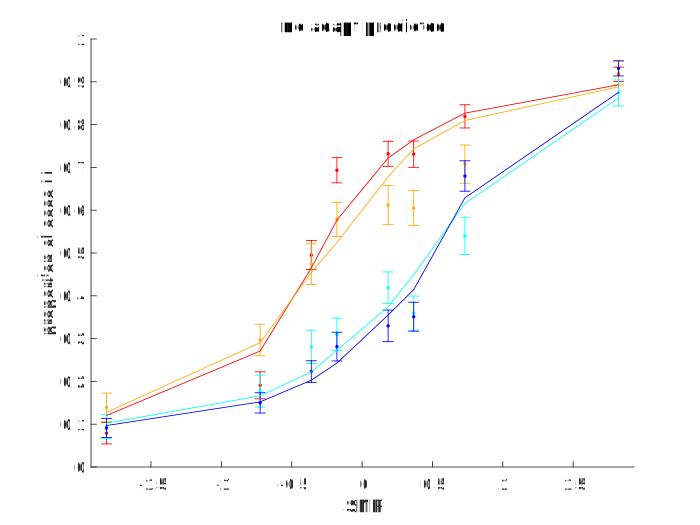

In [24]:
jet11 = mat2cell(jet(11),ones(1,11));
jet4 = jet11([2,5,9,11]);
jet4r = flipud(jet4);

figure();hold on;
h_pt_psychod = psycho_plot(datapt_ave_all,'ptC','.',...
    'mean_mean_choice01','sem_mean_choice01',0,'zSNR');
[h_pt_psychod.Color] = jet4r{:}; 
h_pt_psychop = psycho_plot(datapt_ave_all,'ptC','-',...
    'mean_mean_choice_pred',[],0,'zSNR');
[h_pt_psychop.Color] = jet4r{:}; 
    
xlabel('SNR')
ylabel('proportion choose H')
title('no adapt predicted')

### model comparison

In [7]:
llept1 = table();
for i=1:length(fitspt1)
    F = load(fullfile(DATA_DIR,fitspt1(i).fitmat));
    F.fit_stats.model_id = repmat(fitspt1(i).model_id,height(F.fit_stats),1);
    F.fit_stats.mname = cellstr(repmat(fitspt1(i).mname,height(F.fit_stats),1));
    llept1 = [llept1; F.fit_stats];
    clear F
end
llept1.aic = 2.*llept1.nparam - 2.*llept1.LL;

In [8]:
%Group LRTs
llept1_sum = varfun(@sum,llept1,'InputVariables',{'LL','aic'},...
    'GroupingVariables',{'model_id','mname','nparam'})


llept1_sum =

  3x6 table

    model_id          mname           nparam    GroupCount    sum_LL     sum_aic
    ________    __________________    ______    __________    _______    _______

       1        {'full'          }      15          45        -7968.1     17286 
       2        {'no interaction'}       9          45        -8288.1     17386 
       3        {'base'          }       3          45        -9787.3     19845 



In [9]:
%FINAL

fprintf('no int - full: %.2f\n',mean(llept1.aic(llept1.model_id==2) - llept1.aic(llept1.model_id==1)));
fprintf('base - no int: %.2f\n',mean(llept1.aic(llept1.model_id==3) - llept1.aic(llept1.model_id==2)));
fprintf('base - full: %.2f\n',mean(llept1.aic(llept1.model_id==3) - llept1.aic(llept1.model_id==1)));


no int - full: 2.22
base - no int: 54.63
base - full: 56.85


To use the original INDVAR values as table variable names, set 'VariableNamingRule' to 'preserve'.
---
Date: 10-Nov-2021 11:25:55
VB converged in 11 iterations (took ~6 sec).
Dimensions:
     - subjects: n=45
     - models: K=3
Posterior probabilities:
     - RFX: p(H1|y)= 0.995
     - null: p(H0|y)= 0.005


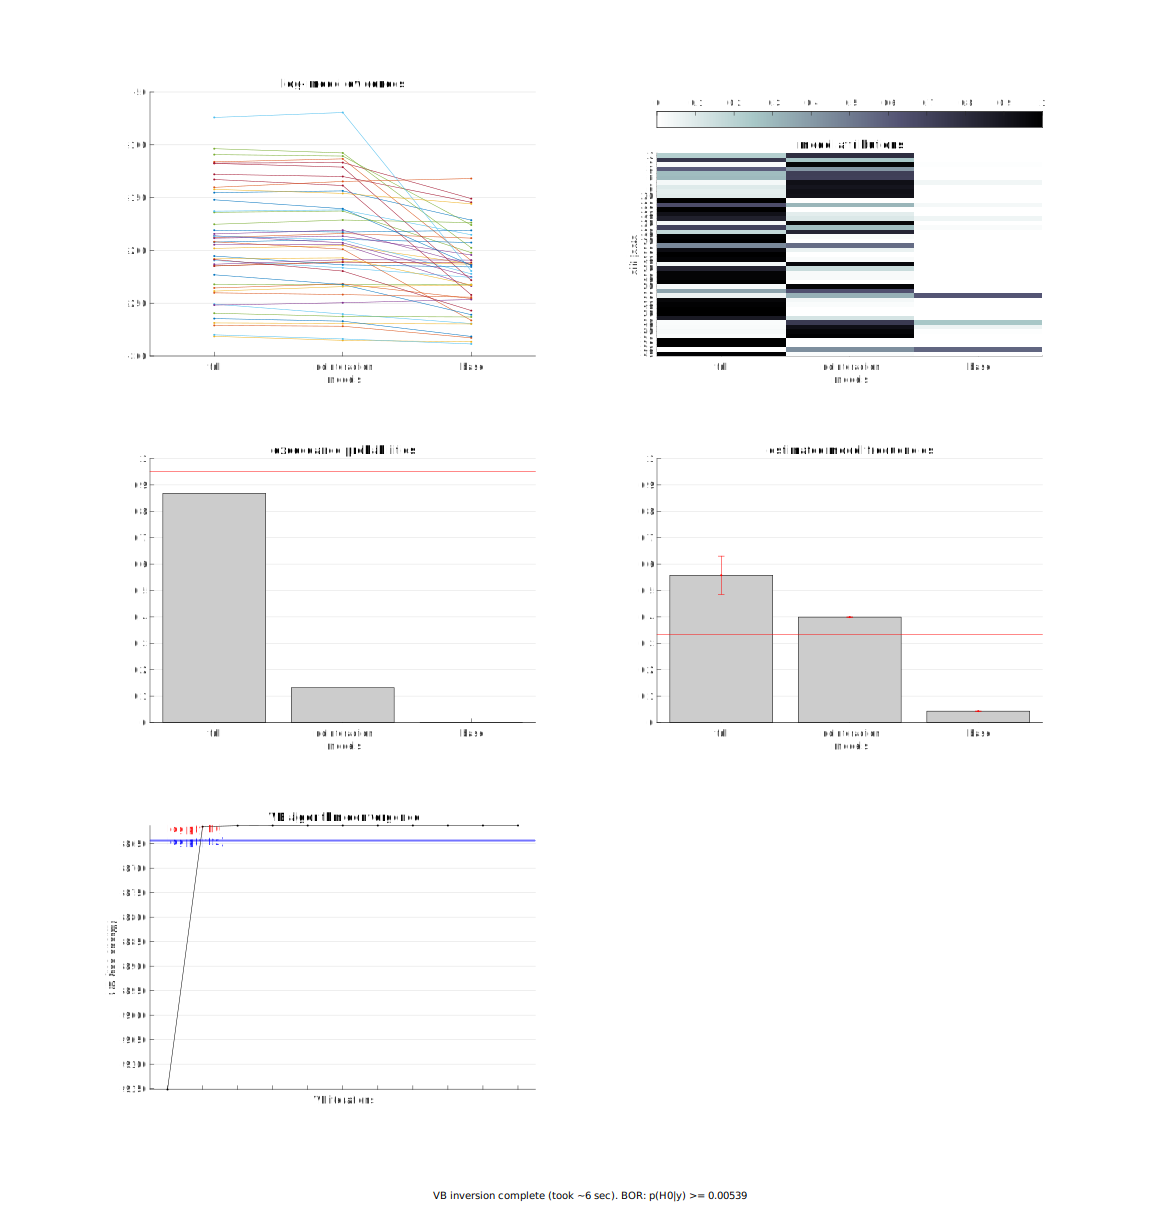

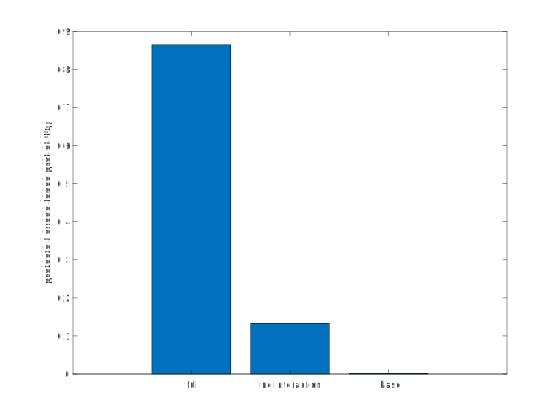

In [10]:
%FINAL

%% now let's look at exceedance probability
llept1_VBA = llept1(:,{'subject','mname','aic'});
%Stephan et al 2009 AIC is normal AIC/-2 ie log(llept1) - k; this is what
%the BMC function expects (I have a question out asking why)
llept1_VBA.aic = llept1_VBA.aic./-2;
llept1_VBA = unstack(llept1_VBA,'aic','mname');
llept1_VBA = movevars(llept1_VBA,'base','After','noInteraction');

opts.MaxIter = 1e4;
opts.modelNames = llept1_VBA.Properties.VariableNames(2:end);

[posterior,out] = VBA_groupBMC(llept1_VBA{:,2:end}',opts);
%compute protected EP: Rigoux et al., 2014. Code from:
%http://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/
out.PEP = (1-out.bor)*out.ep + out.bor/length(out.ep);

out_table = table(out.options.modelNames',out.ep',out.PEP',out.Ef,...
    'VariableNames',{'mname','ep','pep','Ef'});
out_table.mname = strrep(out_table.mname,'noInteraction','no interaction');
    
llept1_sum = join(llept1_sum,out_table,'Keys','mname');

%llept1_sum.ep = out.ep'; %exceedanc pr
%llept1_sum.pep = out.PEP'; %protected ep
%llept1_sum.Ef = out.Ef; %posterior mean of estimated model frequency

%plot protected exceedance probabilities
figure();bar(llept1_sum.model_id,llept1_sum.pep)
xticklabels(llept1_sum.mname)
ylabel('protected exceedance probability')

In [11]:
%FINAL

llept1_sum(:,{'model_id','mname','Ef','pep'})


ans =

  3x4 table

    model_id          mname              Ef          pep   
    ________    __________________    ________    _________

       1        {'full'          }     0.55775      0.86508
       2        {'no interaction'}     0.39926      0.13313
       3        {'base'          }    0.042989    0.0017982



### Parsing out bias vs. adaptation

In [3]:
F = load(fullfile(DATA_DIR,fitspt1(1).fitmat));
ptfx = F.pt_total_fx; clear F


%what is the differential effect of SNR X - SNR 0? 
%(this is just recentering the main effect and interaction since SNR was mean centered, and
%we want bias (the main effect) to be pretone effect at SNR==0

ptfx0 = ptfx(ptfx.aSNR==0,{'subject','total_fx'});
ptfx0.Properties.VariableNames{'total_fx'} = 'total_fx0';
ptfxdiff = join(ptfx(ptfx.aSNR~=0,:),ptfx0,'Keys','subject');
ptfxdiff.total_diff = ptfxdiff.total_fx - ptfxdiff.total_fx0;
%clear ptfx0
ptfxdiff.total_fx0 = [];

ptfx0_med = varfun(@median,ptfx0,'InputVariables',...
    {'total_fx0'});
ptfxdiff_med = varfun(@median,ptfxdiff,'InputVariables',...
    {'total_diff'},'GroupingVariables','aSNR');
head(ptfxdiff_med);

In [4]:
%%now construct bootstrap confidence intervals

nsamp = 10000;

%bootstrap for bias
boot_bias = [];
for i=1:nsamp
    this_boot = datasample(ptfx0.total_fx0,height(ptfx0),1);
    %debugging
    %{
    for j=1:6
        assert(all(ismember(this_boot(:,j),ptfx0.total_fx0(:,j))))
    end
    %}
    this_bias_med = table(i,median(this_boot,1),'VariableNames',{'n','median'});
    boot_bias = [boot_bias;this_bias_med];
end

%bootstrap for adapt
aSNRs = unique(ptfxdiff.aSNR);
%just do the bootstrap for the actual Betas and then scale...when construct CI
adapt_weights = ptfxdiff.total_diff(ptfxdiff.aSNR==.5,:)./.5;
boot_adapt = [];
for i=1:nsamp
    this_boot = datasample(adapt_weights,size(adapt_weights,1),1);
    %debugging
    %{
    for j=1:6
        assert(all(ismember(this_boot(:,j),adapt_weights(:,j))))
    end
    %}
    this_adapt_med = table(i,median(this_boot,1),'VariableNames',{'n','median'});
    boot_adapt = [boot_adapt;this_adapt_med];
end
    
%get bootstrapped confidence intervals (find index of upper/lower CI)
alpha = .05;
CI_lower = nsamp*(alpha/2);
CI_upper = nsamp*(1-alpha/2);

%first for bias
ptfx0_med.CI_lower = nan(1,6);
ptfx0_med.CI_upper = nan(1,6);
for i=1:6
    this_med = sort(boot_bias.median(:,i));
    ptfx0_med.CI_lower(i) = this_med(CI_lower);
    ptfx0_med.CI_upper(i) = this_med(CI_upper);
end
%center CIs on true medians for errorbar func
ptfx0_med.CI_lower = ptfx0_med.median_total_fx0 - ptfx0_med.CI_lower;
ptfx0_med.CI_upper = ptfx0_med.CI_upper - ptfx0_med.median_total_fx0;


%now for adapt
ptfxdiff_med.CI_lower = nan(height(ptfxdiff_med),6);
ptfxdiff_med.CI_upper = nan(height(ptfxdiff_med),6);

for s=1:length(aSNRs)
    for i=1:6
        this_med = sort(boot_adapt.median(:,i).*aSNRs(s));
        ptfxdiff_med.CI_lower(s,i) = this_med(CI_lower);
        ptfxdiff_med.CI_upper(s,i) = this_med(CI_upper);
    end
    %center CIs on true medians for errorbar func
    ptfxdiff_med.CI_lower(s,:) = ptfxdiff_med.median_total_diff(s,:) - ptfxdiff_med.CI_lower(s,:);
    ptfxdiff_med.CI_upper(s,:) = ptfxdiff_med.CI_upper(s,:) - ptfxdiff_med.median_total_diff(s,:);
end

#### Figure 2c (right)

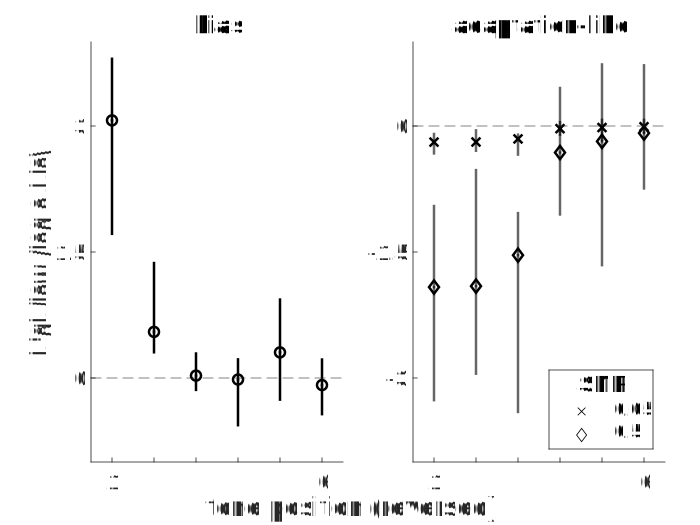

In [7]:
to_print = true;
if to_print
    set(groot,'DefaultAxesFontSize',15)
    set(groot,'DefaultErrorBarCapSize',0)
    this_subplot = @(m,n,p) subtightplot(m,n,p,.1,[.12,.08],[0.13 0.05]);
else
    this_subplot = subplot;
end

ptpos = 1:size(ptfx0_med.median_total_fx0,2);

this_subplot(1,2,1);hold on;
errorbar(ptpos,ptfx0_med.median_total_fx0,ptfx0_med.CI_lower,ptfx0_med.CI_upper,...
    'ok','LineWidth',1.5)
title('bias')
if ~to_print
    xlabel('tone position (reversed)')
end
ylabel('high/low (log odds)')
xlim([0.5 max(ptpos)+.5])
xticks(1:max(ptpos))
xticklabels({'1','','','','','6'})
%ylim([-1 2])
ylim([-1 4])
yticks([0:1.5:6])
yline(0,'--');


this_subplot(1,2,2);hold on;
SNR_disp = [1,4];
line_levels = [.85 NaN NaN 1.5]; %[.5:.4:1.7];
marker_levels = {'x',NaN,NaN,'d'};
for s=SNR_disp %1:height(ptfxdiff_med)
    h=errorbar(ptpos,ptfxdiff_med.median_total_diff(s,:),...
    ptfxdiff_med.CI_lower(s,:),ptfxdiff_med.CI_upper(s,:),[marker_levels{s} 'k'],...
    'LineWidth',1.5);
    %'LineWidth',line_levels(s),'MarkerSize',line_levels(s)*5+1); %1.5);
    % Set transparency level (0:1)
    alpha = 0.6;   
    % Set transparency (undocumented)
    set([h.Bar, h.Line], 'ColorType', 'truecoloralpha', 'ColorData',...
        [h.Line.ColorData(1:3); 255*alpha]);
end
xlim([0.5 max(ptpos)+.5])
xticks(1:max(ptpos))
xticklabels({'1','','','','','6'})
%ylim([-2 .5])
ylim([-4 1])
yticks([-6:1.5:1])
yline(0,'--');
title('adaptation-like')
if ~to_print
    xlabel('tone position (reversed)');
end
%ylabel('SNR_x - SNR_0  [log(OR)]');
legendflex(arrayfun(@num2str,ptfxdiff_med.aSNR(SNR_disp),'UniformOutput',false),...
    'title','\fontsize{14}SNR',...
    'anchor',[5 5],'buffer',[-10 10])

if to_print
    suplabel('tone position (reversed)','x',[.08 .14 .84 .84]);
    set(groot,'DefaultAxesFontSize','factory')
    set(groot,'DefaultErrorBarCapSize','factory')
end